<a href="https://colab.research.google.com/github/LeticiaHu/Doc_Classification/blob/main/Financial_Docs_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧾 Financial Document Classification

Classifying financial documents into predefined categories using supervised learning models.


**Author:** Leticia Huang

**Date:** August 13th

**Class:** CIS 9660 - Data Mining for Business Analytics

**Instructor:** Prof. Mr. Avinash Jairam

---
## 📦 Original Data Source
Source: https://www.kaggle.com/datasets/patrickaudriaz/tobacco3482jpg
}


## 📚 Acknowledgements

- Portions of the code used in data preprocessing and model setup were adapted from instructional materials provided by Prof. Mr. Avinash Jairam as part of the CIS 9660 - Data Mining for Business Analytics course.
- I used ChatGPT (OpenAI) to clarify syntex errors and debug glitches that prevented the code to run on Streamlit cloud.
All final modeling decisions, analysis, conclusions, and interpretations are my own.

# 1. Import required libraries

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from glob import glob
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, validation_curve, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import contingency_matrix
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


import warnings
warnings.filterwarnings('ignore')


In [ ]:
!pip install tensorflow

# 2. Dataset Loading

- Load the original financial document image dataset

- Reduce the dataset size for improved computational performance

- Save the sampled subset to a CSV file for efficient reuse during training


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

zip_path = "/content/drive/MyDrive/Colab Notebooks/Image_classification.zip"
extract_to = "/content/image_classification"

# Unzip it
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("✅ Unzipped to:", extract_to)


✅ Unzipped to: /content/image_classification


## Step 1: Load Image Paths and Labels into a DataFrame

In [ ]:
dataset_path = "/content/image_classification/Tobacco3482-jpg"
image_extensions = ['.jpg', '.jpeg', '.png']

# List all image files and print classes
classes = sorted([folder for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))])
print("Classes found:", classes)

data = []

# Walk through all class folders
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for ext in image_extensions:
            pattern = os.path.join(class_path, f"*{ext}")
            for file_path in glob(pattern):
                data.append((file_path, class_name))

# Create fresh DataFrame
df = pd.DataFrame(data, columns=["filepath", "label"])
print(f"Data size: {len(df)} image records")
df.head()


Classes found: ['ADVE', 'Email', 'Form', 'Letter', 'Memo', 'News', 'Note', 'Report', 'Resume', 'Scientific']
Data size: 3482 image records


,filepath,label
0,/content/image_classification/Tobacco3482-jpg/...,Memo
1,/content/image_classification/Tobacco3482-jpg/...,Memo
2,/content/image_classification/Tobacco3482-jpg/...,Memo
3,/content/image_classification/Tobacco3482-jpg/...,Memo
4,/content/image_classification/Tobacco3482-jpg/...,Memo


Original Dataset Structure

In [ ]:
print(f"Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nDataset Info:")
print(df.info())
print("\nDataset Description:")
print(df.describe())

Dataset loaded successfully!
Dataset shape: (3482, 2)
Columns: ['filepath', 'label']

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3482 entries, 0 to 3481
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filepath  3482 non-null   object
 1   label     3482 non-null   object
dtypes: object(2)
memory usage: 54.5+ KB
None

Dataset Description:
                                                 filepath label
count                                                3482  3482
unique                                               3482    10
top     /content/image_classification/Tobacco3482-jpg/...  Memo
freq                                                    1   620


Plotting the distribution of image classes on original dataset

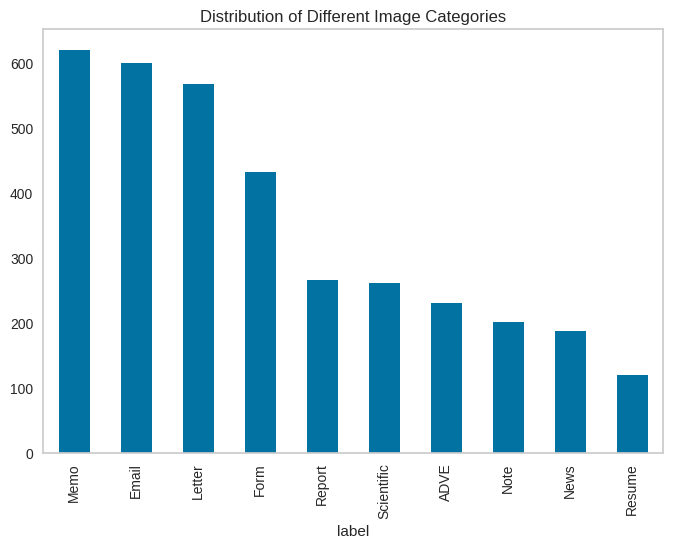

In [ ]:
df['label'].value_counts().plot(kind='bar', grid=False)
plt.title('Distribution of Different Image Categories')
plt.show()

## Step 2: Reduce the dataset size for improved computational performance

In [ ]:
# 120 images per class (tune to keep <100MB)
per_class = 120

df_small  = (df.groupby("label", group_keys=False)
              .apply(lambda x: x.sample(min(len(x), per_class), random_state=42))
              .reset_index(drop=True))

print(df['label'].value_counts())
df_small.to_csv("df_small.csv", index=False)  # Save to load later

label
Memo          620
Email         599
Letter        567
Form          431
Report        265
Scientific    261
ADVE          230
Note          201
News          188
Resume        120
Name: count, dtype: int64


# 3. Exploring the dataset

In [ ]:
print(f"Dataset loaded successfully!")
print(f"Dataset shape: {df_small.shape}")
print(f"Columns: {df_small.columns.tolist()}")
print("\nDataset Info:")
print(df_small.info())
print("\nFirst 5 rows:")
print(df_small.head())
print("\nDataset Description:")
print(df_small.describe())

Dataset loaded successfully!
Dataset shape: (1200, 2)
Columns: ['filepath', 'label']

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filepath  1200 non-null   object
 1   label     1200 non-null   object
dtypes: object(2)
memory usage: 18.9+ KB
None

First 5 rows:
                                            filepath label
0  /content/image_classification/Tobacco3482-jpg/...  ADVE
1  /content/image_classification/Tobacco3482-jpg/...  ADVE
2  /content/image_classification/Tobacco3482-jpg/...  ADVE
3  /content/image_classification/Tobacco3482-jpg/...  ADVE
4  /content/image_classification/Tobacco3482-jpg/...  ADVE

Dataset Description:
                                                 filepath label
count                                                1200  1200
unique                                               1200    10
top     /cont

# 4. Check for missing values and duplicates

In [ ]:
print(f"\nMissing values:")
print(df_small.isnull().sum())


Missing values:
filepath    0
label       0
dtype: int64


In [ ]:
df_small.duplicated().sum()
duplicates = df_small.drop_duplicates(subset="filepath", inplace=True)
print(duplicates)

None


In [ ]:
# Run this line to make sure our dataset is clean of Nas
df_small.dropna(inplace=True)

# 5. Check target variable distribution

In [ ]:
print(f'Dataset Original shape: {df.shape}')
print(f'Dataset shape: {df_small.shape}')

Dataset Original shape: (3482, 2)
Dataset shape: (1200, 2)


### Display sample images for each category

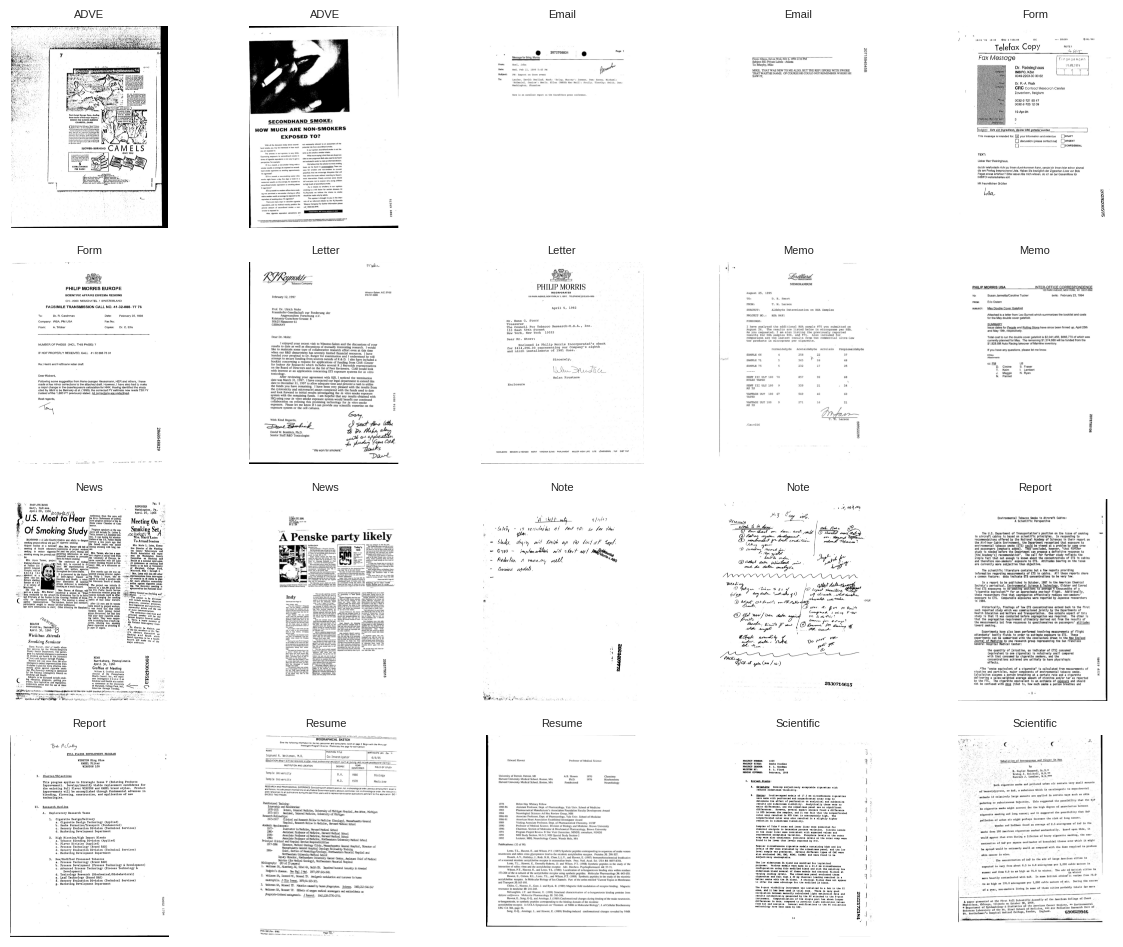

In [ ]:
# Group and sample 2 per class
df_min_samples = df_small.groupby("label", group_keys=False).apply(lambda x: x.sample(min(2, len(x)), random_state=42))

# Fill up to 20 total samples with additional random ones (excluding already selected)
remaining_needed = 20 - len(df_min_samples)
df_remaining = df_small[~df_small.index.isin(df_min_samples.index)].sample(remaining_needed, random_state=42)

# Combine both
sample_df = pd.concat([df_min_samples, df_remaining]).reset_index(drop=True)

# 🖼 Plot the images
plt.figure(figsize=(12, 12))
for idx, (filepath, label) in enumerate(zip(sample_df["filepath"], sample_df["label"])):
    try:
        img = Image.open(filepath).convert("L")  # Grayscale
        plt.subplot(5, 5, idx + 1)
        plt.imshow(img, cmap="gray")
        plt.title(label, fontsize=8)
        plt.axis("off")
    except Exception as e:
        print(f"⚠️ Could not open image: {filepath} ({e})")

plt.tight_layout()
plt.show()
sample_df.to_csv("sample_images.csv", index=False)


### Create sample of image files and csv file to use on Streamlit dashboard as a comparasion between image uploaded and original images


In [ ]:
import shutil
import zipfile
from pathlib import Path

## Load image file into a dataframe
df_full = pd.read_csv("/content/df_small.csv")

# Normalize label column
df_full["label"] = df_full["label"].str.strip().str.lower()

# Encode original labels directly
label_encoder = {label: idx for idx, label in enumerate(sorted(df_full["label"].unique()))}
df_full["encoded_label"] = df_full["label"].map(label_encoder)

# Update filepath for Streamlit (just filename in "sample_images/")
sample_df["filepath"] = sample_df["filepath"].apply(lambda x: f"sample_images/{os.path.basename(x)}")

# Save the final CSV for Streamlit
sample_df.to_csv("sample_df.csv", index=False)

# Copy images from original dataset into `sample_images/`
filepath_lookup = {
    os.path.basename(path): path for path in df_full["filepath"]
}
#  Create the destination folder
Path("sample_images").mkdir(parents=True, exist_ok=True)

# Loop through each image in the sample
for filename in sample_df["filepath"].apply(os.path.basename):
    if filename in filepath_lookup:
        src = filepath_lookup[filename] # original full path of image.
        dst = os.path.join("sample_images", filename) # Path in destination folder
        try:
            shutil.copy(src, dst)
        except Exception as e:
            print(f" Could not copy {src} → {dst} ({e})")
    else:
        print(f" Filename not found in full dataset: {filename}")

# Zip  and save files for export
with zipfile.ZipFile("financial_doc_sample1.zip", 'w') as zipf:
    zipf.write("sample_df.csv")
    for image_file in os.listdir("sample_images"):
        image_path = os.path.join("sample_images", image_file)
        zipf.write(image_path)

print(" All done! Created 'sample_df.csv' and zipped images.")

 All done! Created 'sample_df.csv' and zipped images.


#6. Data Visualizations

Text(0.5, 1.0, 'Distribution of Sampled Financial Documents Classes')

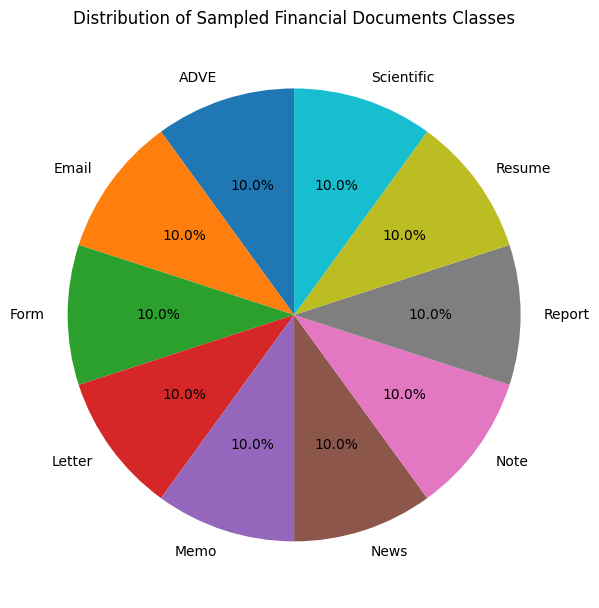

In [ ]:
# SET up the ploting style
plt.style.use('default')
fig = plt.figure(figsize=(35, 25))

# visualize the #1 : Target distribution
plt.subplot(3,4,1)
label_counts = df_small['label'].value_counts()
plt.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Sampled Financial Documents Classes')

 ### Step 1: Convert Images → Features (grayscale, resize, flatten)

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array


# Load data
df = pd.read_csv("df_small.csv")
BATCH_SIZE = 64
IMAGE_SIZE = (224, 224)

# Load MobileNetV2 model
mobilenet = MobileNetV2(weights="imagenet", include_top=False, pooling="avg", input_shape=(224, 224, 3))
print(" MobileNetV2 loaded")

# Prepare accumulators
features = []
labels = []

batch_images = []
batch_labels = []

# Loop through all images
for idx, (path, label) in tqdm(enumerate(zip(df["filepath"], df["label"])), total=len(df)):
    try:
        img = load_img(path, target_size=IMAGE_SIZE)
        img_array = img_to_array(img)
        img_array = preprocess_input(img_array)
        batch_images.append(img_array)
        batch_labels.append(label)

        # Process batch
        if len(batch_images) == BATCH_SIZE or idx == len(df) - 1:
            batch_input = np.array(batch_images)
            batch_features = mobilenet.predict(batch_input, verbose=0)
            features.append(batch_features)
            labels.extend(batch_labels)

            # Reset batch
            batch_images = []
            batch_labels = []

    except Exception as e:
        print(f"⚠️ Skipped: {path} ({e})")
        continue

# Stack all batch outputs into a final array
X = np.vstack(features)  # Shape: (n_samples, 1280)
y = np.array(labels) # label for each category

print(f"✅ Extracted features: {X.shape}, labels: {y.shape}")

# Save to disk
np.save("mobilenet_features.npy", X)
np.save("mobilenet_labels.npy", y)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
 MobileNetV2 loaded


100%|██████████| 1200/1200 [01:59<00:00, 10.07it/s]

✅ Extracted features: (1200, 1280), labels: (1200,)


In [ ]:
# Saving Model for Streamlit
mobilenet.save("mobilenet_features.h5")

#7. Data Preprocessing

Encode and split the data

In [ ]:
# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"Original classes: {label_encoder.classes_}")
print(f"Encoded classes: {np.unique(y_encoded)}")
print()
# Skipping a line

# Split the data(70:30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

print(f'Original Classes: {label_encoder.classes_}')
print(f'Encoded Classes: {np.unique(y_encoded)}')


Original classes: ['ADVE' 'Email' 'Form' 'Letter' 'Memo' 'News' 'Note' 'Report' 'Resume'
 'Scientific']
Encoded classes: [0 1 2 3 4 5 6 7 8 9]

Training set size: (840, 1280)
Test set size: (360, 1280)
Original Classes: ['ADVE' 'Email' 'Form' 'Letter' 'Memo' 'News' 'Note' 'Report' 'Resume'
 'Scientific']
Encoded Classes: [0 1 2 3 4 5 6 7 8 9]


# 8. Standardization

In [ ]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Scaled data ready for training.")
# Print the mean and standard deviation of the arrays directly
print(f'Original Features Mean: {X_train.mean().round(3)}')
print(f'Original Features Std Dev: {X_train.std().round(3)}')
print(f'Scaled Feature Means: {np.mean(X_train_scaled).round(3)}')
print(f'Scaled Feature Std Devs: {np.std(X_train_scaled).round(3)}')

✅ Scaled data ready for training.
Original Features Mean: 0.24500000476837158
Original Features Std Dev: 0.5640000104904175
Scaled Feature Means: 0.0
Scaled Feature Std Devs: 1.0


#9. Finding Optimal K for KNN

Testing k values: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Optimal K value: 6
Best Validation Accuracy: 0.5536


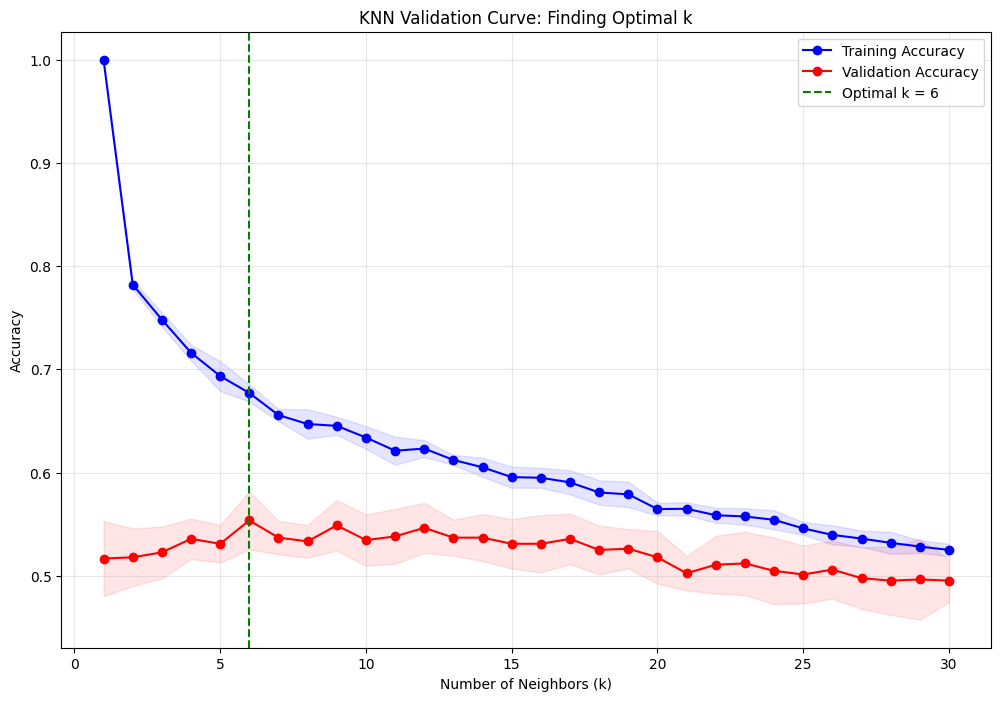


5b. Testing Different Distance Metrics for k=6...
Distance metric 'euclidean': CV Accuracy = 0.5536
Distance metric 'manhattan': CV Accuracy = 0.4631
Distance metric 'minkowski': CV Accuracy = 0.5536
Best distance metric: euclidean


In [ ]:
from sklearn.decomposition import PCA

# Reduce dimensionality to make KNN faster
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)


# Run validation curve with fast KNN (KD Tree)
k_range = np.arange(1, 31)
print(f"Testing k values: {k_range}")

train_scores, val_scores = validation_curve(
    KNeighborsClassifier(algorithm='kd_tree'),  # Faster distance search
    X_train_pca, y_train, param_name='n_neighbors',
    param_range=k_range, cv=5, scoring='accuracy', n_jobs=-1
)

# # Calculate mean and std for training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Find optimal k
optimal_k_idx = np.argmax(val_mean)
optimal_k = k_range[optimal_k_idx]

print(f'Optimal K value: {optimal_k}')
print(f'Best Validation Accuracy: {val_mean[optimal_k_idx]:.4f}')


# Plot validation curve for KNN
plt.figure(figsize=(12, 8))
plt.plot(k_range, train_mean, 'o-', color='blue', label='Training Accuracy')
plt.fill_between(k_range, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(k_range, val_mean, 'o-', color='red', label='Validation Accuracy')
plt.fill_between(k_range, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')
plt.axvline(x=optimal_k, color='green', linestyle='--', label=f'Optimal k = {optimal_k}')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN Validation Curve: Finding Optimal k')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Additional analysis: Different distance metrics for optimal k
print(f"\n5b. Testing Different Distance Metrics for k={optimal_k}...")

distance_metrics = ['euclidean', 'manhattan', 'minkowski']
distance_scores = {}

for metric in distance_metrics:
    knn = KNeighborsClassifier(n_neighbors=optimal_k, metric=metric)
    scores = cross_val_score(knn, X_train_pca, y_train, cv=5, scoring='accuracy')
    distance_scores[metric] = scores.mean()
    print(f"Distance metric '{metric}': CV Accuracy = {scores.mean():.4f}")

best_metric = max(distance_scores, key=distance_scores.get)
print(f"Best distance metric: {best_metric}")

# 10. Model Implementation

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'SVM (Linear)': SVC(kernel='linear', random_state=42),
    'SVM (RBF)': SVC(kernel='rbf', random_state=42),
    'SVM (Polynomial)': SVC(kernel='poly', degree=3, random_state=42),
    'SVM (Sigmoid)': SVC(kernel='sigmoid', random_state=42),
    'SVM (RBF-Tuned)': SVC(kernel='rbf', C=10, gamma='scale', random_state=42),
    'K-Nearest Neighbors (Default)': KNeighborsClassifier(n_neighbors=5),
    f'K-Nearest Neighbors (Optimal k={optimal_k})': KNeighborsClassifier(
        n_neighbors=optimal_k, metric=best_metric
    )
}

print(f"Models to be evaluated:")
for name, model in models.items():
    print(f" -  {name}")

Models to be evaluated:
 -  Logistic Regression
 -  Naive Bayes
 -  Decision Tree
 -  Random Forest
 -  SVM (Linear)
 -  SVM (RBF)
 -  SVM (Polynomial)
 -  SVM (Sigmoid)
 -  SVM (RBF-Tuned)
 -  K-Nearest Neighbors (Default)
 -  K-Nearest Neighbors (Optimal k=6)


# 11. Cross Validation

Evaluating Logistic Regression...
  CV Accuracy: 0.6381 (+/- 0.0524)


Evaluating Naive Bayes...
  CV Accuracy: 0.4202 (+/- 0.0430)


Evaluating Decision Tree...
  CV Accuracy: 0.4214 (+/- 0.0688)


Evaluating Random Forest...
  CV Accuracy: 0.6179 (+/- 0.0545)


Evaluating SVM (Linear)...
  CV Accuracy: 0.6310 (+/- 0.0607)


Evaluating SVM (RBF)...
  CV Accuracy: 0.6083 (+/- 0.0454)


Evaluating SVM (Polynomial)...
  CV Accuracy: 0.2738 (+/- 0.0391)


Evaluating SVM (Sigmoid)...
  CV Accuracy: 0.6095 (+/- 0.0847)


Evaluating SVM (RBF-Tuned)...
  CV Accuracy: 0.6345 (+/- 0.0456)


Evaluating K-Nearest Neighbors (Default)...
  CV Accuracy: 0.5321 (+/- 0.0410)


Evaluating K-Nearest Neighbors (Optimal k=6)...
  CV Accuracy: 0.5274 (+/- 0.0619)




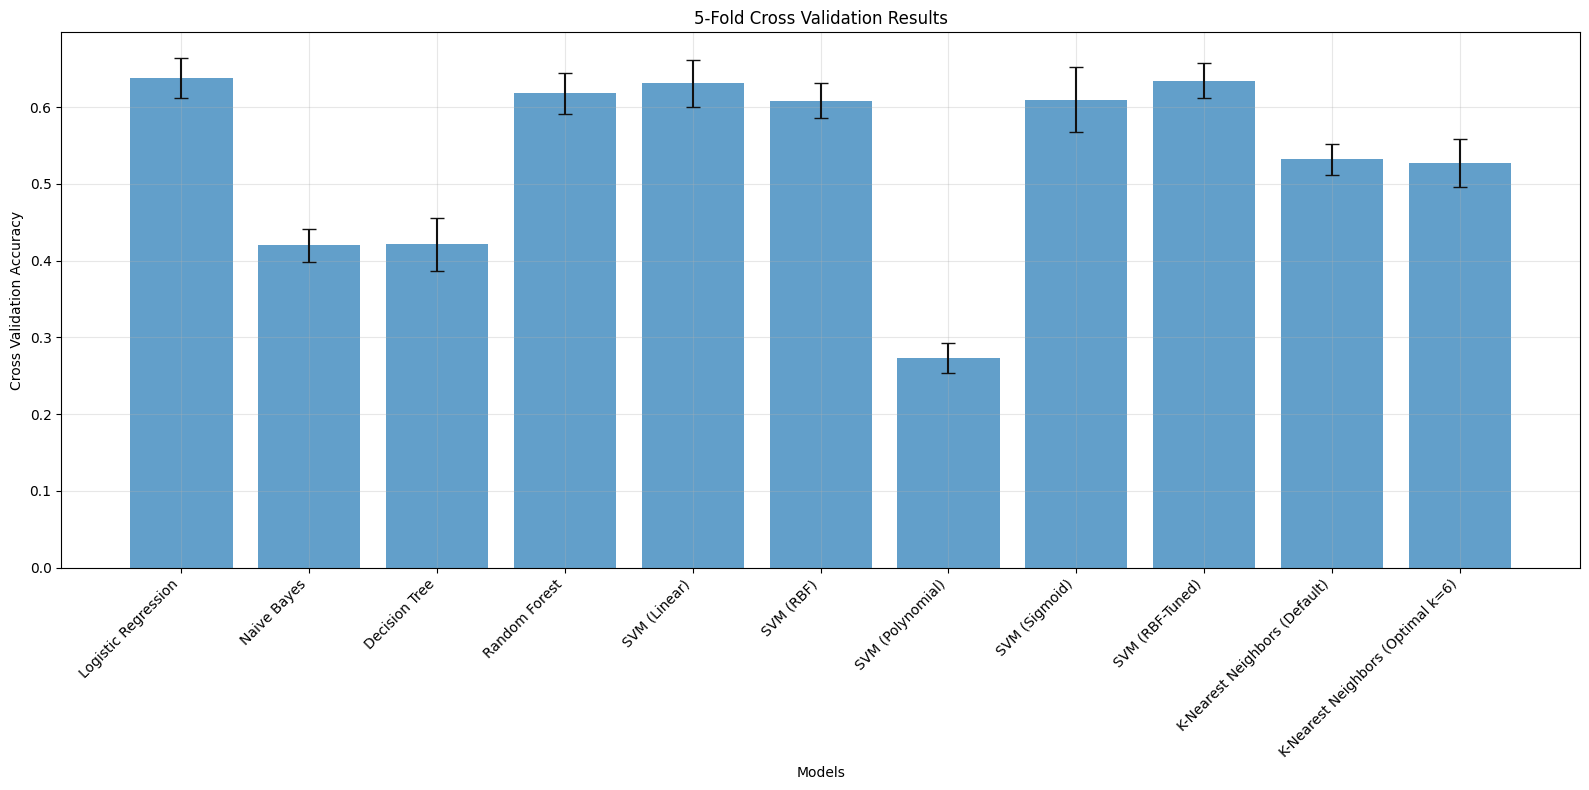

In [ ]:
# Train each classifier and evaluate using  cross-validation
cv_scores = {}
cv_folds = 5
kfold = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"Evaluating {name}...")
    scores = cross_val_score(model, X_train_scaled, y_train, cv=kfold, scoring='accuracy', n_jobs=-1)
    cv_scores[name] = scores
    print(f"  CV Accuracy: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
    print('\n')

# Plot cross validation results
plt.figure(figsize=(16, 8))
model_names = list(cv_scores.keys())
cv_means = [cv_scores[name].mean() for name in model_names]
cv_stds = [cv_scores[name].std() for name in model_names]

plt.bar(range(len(model_names)), cv_means, yerr=cv_stds, capsize=5, alpha=0.7)
plt.xlabel('Models')
plt.ylabel('Cross Validation Accuracy')
plt.title('5-Fold Cross Validation Results')
plt.xticks(range(len(model_names)), model_names, rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 12. Model Training and Testing

In [ ]:
# dictionaries to store metrics
trained_models = {}
predictions = {}
test_accuracies = {}

for name, model in models.items():
    print(f"Training {name}...")
    # Train the model
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    predictions[name] = y_pred

    # Calculate test accuracy
    test_accuracy = accuracy_score(y_test, y_pred)
    test_accuracies[name] = test_accuracy

    print(f"  Test Accuracy: {test_accuracy:.4f}")
    print()

Training Logistic Regression...
  Test Accuracy: 0.6361

Training Naive Bayes...
  Test Accuracy: 0.4056

Training Decision Tree...
  Test Accuracy: 0.3917

Training Random Forest...
  Test Accuracy: 0.5972

Training SVM (Linear)...
  Test Accuracy: 0.6194

Training SVM (RBF)...
  Test Accuracy: 0.5583

Training SVM (Polynomial)...
  Test Accuracy: 0.3028

Training SVM (Sigmoid)...
  Test Accuracy: 0.5833

Training SVM (RBF-Tuned)...
  Test Accuracy: 0.6000

Training K-Nearest Neighbors (Default)...
  Test Accuracy: 0.5194

Training K-Nearest Neighbors (Optimal k=6)...
  Test Accuracy: 0.4917



# 13. Model Evaluation - Generating Classification Reports and Performance Metrics

In [ ]:
classification_reports = {}
performance_metrics = {}

for name in models.keys():
  print(f'\n==={name}===')

  # classfication report
  report = classification_report(y_test, predictions[name],
                                 target_names = label_encoder.classes_,
                                 output_dict= True)

  classification_reports[name] = report

  # print the report
  print(classification_report(y_test, predictions[name], target_names = label_encoder.classes_))

  # Extract performance metrics
  performance_metrics[name] = {
                                'accuracy': report['accuracy'],
                                'precision': report['weighted avg']['precision'],
                                'recall': report['weighted avg']['recall'],
                                'f1_score': report['weighted avg']['f1-score']
                             }


===Logistic Regression===
              precision    recall  f1-score   support

        ADVE       1.00      0.83      0.91        36
       Email       0.93      0.78      0.85        36
        Form       0.67      0.78      0.72        36
      Letter       0.44      0.47      0.45        36
        Memo       0.33      0.36      0.35        36
        News       0.83      0.83      0.83        36
        Note       0.71      0.75      0.73        36
      Report       0.55      0.50      0.52        36
      Resume       0.55      0.72      0.63        36
  Scientific       0.46      0.33      0.39        36

    accuracy                           0.64       360
   macro avg       0.65      0.64      0.64       360
weighted avg       0.65      0.64      0.64       360


===Naive Bayes===
              precision    recall  f1-score   support

        ADVE       0.51      0.83      0.63        36
       Email       0.89      0.67      0.76        36
        Form       0.59      0.4

In [ ]:
metrics_df = pd.DataFrame(performance_metrics).T
print("\nPerformance Metrics Summary:")
print(metrics_df.round(4))


Performance Metrics Summary:
                                   accuracy  precision  recall  f1_score
Logistic Regression                  0.6361     0.6473  0.6361    0.6374
Naive Bayes                          0.4056     0.4074  0.4056    0.3955
Decision Tree                        0.3917     0.4152  0.3917    0.4003
Random Forest                        0.5972     0.6093  0.5972    0.6000
SVM (Linear)                         0.6194     0.6285  0.6194    0.6211
SVM (RBF)                            0.5583     0.5978  0.5583    0.5625
SVM (Polynomial)                     0.3028     0.6367  0.3028    0.2942
SVM (Sigmoid)                        0.5833     0.5940  0.5833    0.5846
SVM (RBF-Tuned)                      0.6000     0.6267  0.6000    0.6041
K-Nearest Neighbors (Default)        0.5194     0.5742  0.5194    0.5246
K-Nearest Neighbors (Optimal k=6)    0.4917     0.5540  0.4917    0.4986


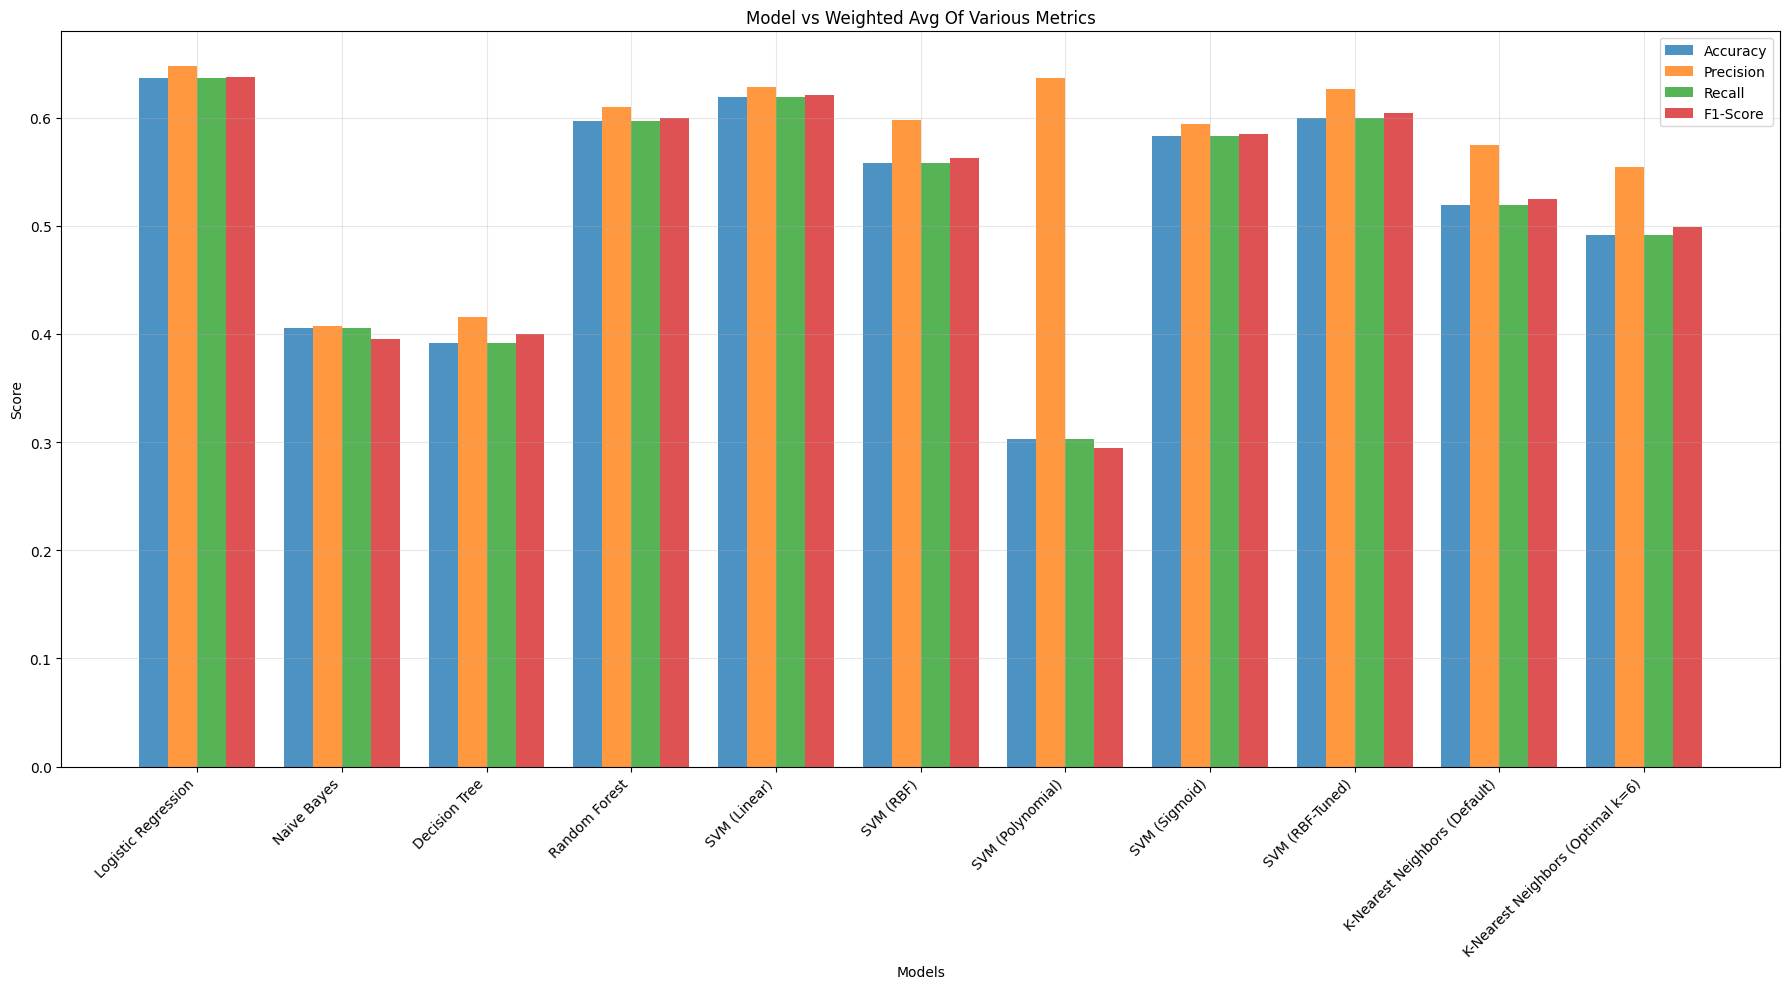

In [ ]:
# Plot performance metrics
plt.figure(figsize=(18, 10))

# Create the comparison plot as requested
x = np.arange(len(models))
width = 0.2

plt.bar(x - 1.5*width, metrics_df['accuracy'], width, label='Accuracy', alpha=0.8)
plt.bar(x - 0.5*width, metrics_df['precision'], width, label='Precision', alpha=0.8)
plt.bar(x + 0.5*width, metrics_df['recall'], width, label='Recall', alpha=0.8)
plt.bar(x + 1.5*width, metrics_df['f1_score'], width, label='F1-Score', alpha=0.8)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model vs Weighted Avg Of Various Metrics')
plt.xticks(x, metrics_df.index, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 14. K-Means Clustering Analysis

In [ ]:
! pip install kneed

 Finding optimal K using Elbow Method...
 Optimal number of clusters (k): 7


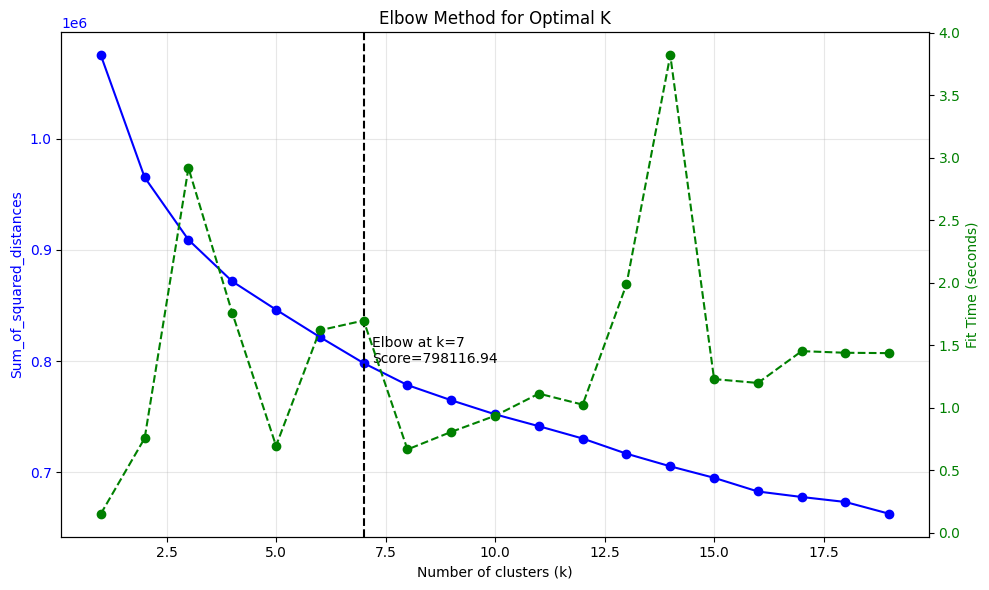

In [ ]:
import time
from sklearn.cluster import KMeans
from kneed import KneeLocator

print(" Finding optimal K using Elbow Method...")
X_kmeans = X_train_scaled

# Check from k = 1 to 20
k_range = range(1, 20)
inertias = []
fit_times = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    start_time = time.time()
    kmeans.fit(X_kmeans)
    end_time = time.time()

    inertias.append(kmeans.inertia_)
    fit_times.append(end_time - start_time)

# Use KneeLocator to find the optimal number of clusters
kneedle = KneeLocator(k_range, inertias, curve="convex", direction="decreasing")
elbow_k = kneedle.elbow or 1  # Fallback to 1 if not found
elbow_score = inertias[elbow_k - 1]

print(f" Optimal number of clusters (k): {elbow_k}")

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot distortion (inertia)
ax1.plot(k_range, inertias, 'o-', color='blue', label='Distortion (Inertia)')
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Sum_of_squared_distances', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title("Elbow Method for Optimal K")
ax1.grid(True, alpha=0.3)

# Mark elbow point
ax1.axvline(x=elbow_k, linestyle='--', color='black')
ax1.text(elbow_k + 0.2, elbow_score, f'Elbow at k={elbow_k}\nScore={elbow_score:.2f}',
         fontsize=10, color='black')

# Plot fit time on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(k_range, fit_times, 'o--', color='green', label='Fit Time')
ax2.set_ylabel('Fit Time (seconds)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

plt.tight_layout()
plt.show()

In [45]:
# Apply K-means with optimal K (let's use k=10 based on the classes we have)
optimal_k_means = len(np.unique(y_encoded))
print(f"\nApplying K-Means with k={optimal_k_means}...")

kmeans = KMeans(n_clusters=optimal_k_means, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_train)

# Add K-means as a "model" for comparison
kmeans_predictions = kmeans.predict(X_test)
kmeans_accuracy = accuracy_score(y_test, kmeans_predictions)

print(f"K-Means clustering accuracy: {kmeans_accuracy:.4f}")


Applying K-Means with k=10...
K-Means clustering accuracy: 0.0389


# 15. Finding the best model

In [46]:
# Find best performing model
best_model_name = max(test_accuracies, key=test_accuracies.get)
best_accuracy = test_accuracies[best_model_name]

print(f"Best performing model: {best_model_name}")
print(f"Best test accuracy: {best_accuracy:.4f}")

# Display top 5 models
sorted_models = sorted(test_accuracies.items(), key=lambda x: x[1], reverse=True)
print("\nTop 5 performing models:")
for i, (name, accuracy) in enumerate(sorted_models[:5], 1):
    print(f"{i}. {name}: {accuracy:.4f}")

Best performing model: Logistic Regression
Best test accuracy: 0.6361

Top 5 performing models:
1. Logistic Regression: 0.6361
2. SVM (Linear): 0.6194
3. SVM (RBF-Tuned): 0.6000
4. Random Forest: 0.5972
5. SVM (Sigmoid): 0.5833


# 16. Confusion Matrix For Best Model

Confusion Matrix for Best Model (Logistic Regression)...


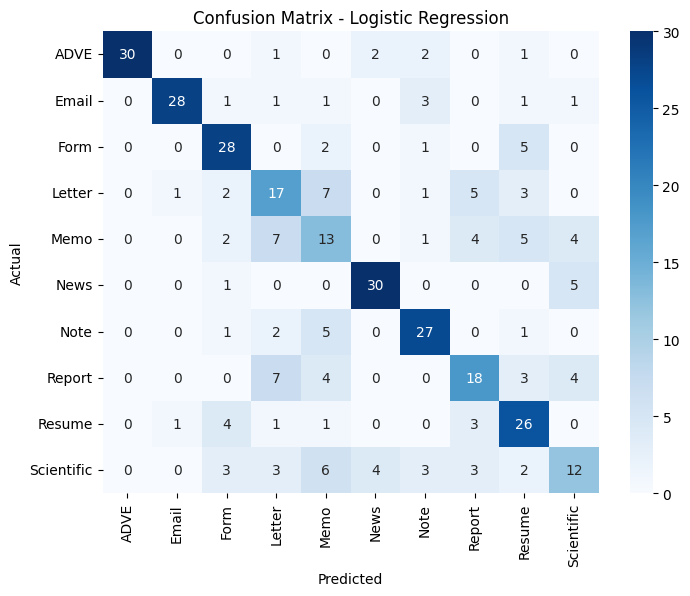

In [47]:
print(f"Confusion Matrix for Best Model ({best_model_name})...")

# Create confusion matrix
cm = confusion_matrix(y_test, predictions[best_model_name])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 17. Summary

In [48]:
print("\n" + "="*60)
print("COMPREHENSIVE ANALYSIS SUMMARY")
print("="*60)

print(f"\nDataset: Financial Documents Classification")
print(f"Total samples: {len(df)}")
print(f"Features: {X.shape[1]}")
print(f"Classes: {len(label_encoder.classes_)} ({', '.join(label_encoder.classes_)})")

print(f"\nKNN Optimization Results:")
default_knn_acc = test_accuracies.get("K-Nearest Neighbors (Default)")
optimal_knn_key = f"K-Nearest Neighbors (Optimal k={optimal_k})"
optimal_knn_acc = test_accuracies.get(optimal_knn_key)

if default_knn_acc is not None:
    print(f"├── Default k=5 accuracy: {default_knn_acc:.4f}")
else:
    print(f"├── Default k=5 accuracy: N/A")

if optimal_knn_acc is not None:
    print(f"├── Optimal k={optimal_k} accuracy: {optimal_knn_acc:.4f}")
else:
    print(f"├── Optimal k={optimal_k} accuracy: N/A")

print(f"\nBest Overall Model: {best_model_name}")
print(f"Best Accuracy: {best_accuracy:.4f}")

print(f"\nCross Validation Results (Top 5):")
cv_sorted = sorted([(name, scores.mean()) for name, scores in cv_scores.items()],
                   key=lambda x: x[1], reverse=True)
for i, (name, score) in enumerate(cv_sorted[:5], 1):
    print(f"{i}. {name}: {score:.4f}")

print(f"\nTest Accuracy Results (Top 5):")
for i, (name, accuracy) in enumerate(sorted_models[:5], 1):
    print(f"{i}. {name}: {accuracy:.4f}")

# K-Means (ARI or matching accuracy score)
print(f"\nK-Means Clustering Accuracy (Clustering vs True Labels): {kmeans_accuracy:.4f}")

print(f"\nKey Insights:")
if 'Random Forest' in trained_models and 'feature_importance' in globals() and not feature_importance.empty:
    top_features = feature_importance.head(3)['feature'].tolist()
    print(f"├── Most important features: {top_features}")
else:
    print(f"├── Most important features: N/A (Feature importance not available or not computed)")

print(f"└── Supervised learning outperformed unsupervised (K-Means) by {best_accuracy - kmeans_accuracy:.4f}.")
print("\n" + "="*60)



COMPREHENSIVE ANALYSIS SUMMARY

Dataset: Financial Documents Classification
Total samples: 1200
Features: 1280
Classes: 10 (ADVE, Email, Form, Letter, Memo, News, Note, Report, Resume, Scientific)

KNN Optimization Results:
├── Default k=5 accuracy: 0.5194
├── Optimal k=6 accuracy: 0.4917

Best Overall Model: Logistic Regression
Best Accuracy: 0.6361

Cross Validation Results (Top 5):
1. Logistic Regression: 0.6381
2. SVM (RBF-Tuned): 0.6345
3. SVM (Linear): 0.6310
4. Random Forest: 0.6179
5. SVM (Sigmoid): 0.6095

Test Accuracy Results (Top 5):
1. Logistic Regression: 0.6361
2. SVM (Linear): 0.6194
3. SVM (RBF-Tuned): 0.6000
4. Random Forest: 0.5972
5. SVM (Sigmoid): 0.5833

K-Means Clustering Accuracy (Clustering vs True Labels): 0.0389

Key Insights:
├── Most important features: N/A (Feature importance not available or not computed)
└── Supervised learning outperformed unsupervised (K-Means) by 0.5972.



# 18. Save results for deployment preparation

In [ ]:
print("="*60)

# Save results for deployment preparation
print(f"\nSaving best model ({best_model_name}) for deployment...")
import joblib

# Save the best model and scaler
joblib.dump(trained_models[best_model_name], 'best_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')
joblib.dump(pca, "pca.pkl")

print("Model artifacts saved successfully!")
print("Files saved: best_model.pkl, scaler.pkl, label_encoder.pkl, pca.pkl")


Saving best model (Logistic Regression) for deployment...
Model artifacts saved successfully!
Files saved: best_model.pkl, scaler.pkl, label_encoder.pkl, pca.pkl
